# Introducción y presentación del problema

Este trabajo aborda un caso sencillo y representativo de **NLP + Deep Learning**: predecir el “sentimiento” asociado a un libro a partir de su **sinopsis** (`book_details`). Como proxy de sentimiento utilizo la **valoración promedio** en Goodreads (`average_rating`), definiendo una etiqueta binaria: **positivo** si `average_rating ≥ 4` y **negativo/moderado** en caso contrario.

El análisis se realiza sobre el dataset **Goodreads (mayo 2024)**, con aproximadamente 16 mil registros y 15 columnas.

Primero se entrena un modelo base (TF-IDF + MLP simple) para tener un punto de comparación. Luego se entrena el mismo modelo pero con regularización (L2, Dropout y callbacks), con el objetivo de reducir el sobreajuste y que el desempeño en test mejore.

El dataset utilizado proviene de Kaggle:
[Books Dataset (Goodreads, May 2024)](https://www.kaggle.com/datasets/dk123891/books-dataset-goodreadsmay-2024)

## Objetivos del proyecto

- **NLP mínimo**: aplicar preprocesamientos clásicos sobre `book_details` (minúsculas, remoción de puntuación, stopwords en inglés y lematización) y representar el texto con **TF-IDF**.
- **DL mínimo**: entrenar una **red neuronal sencilla** (MLP) para clasificación binaria del sentimiento.
- **Profundización**: comparar el **modelo base** con una versión **mejorada** (capas adicionales y regularización: L2/Dropout + callbacks) y analizar el impacto en las métricas.
- **Calidad de entrega**: documentar decisiones, mostrar EDA breve y reportar resultados en test (Accuracy, Precision, Recall, F1 y matriz de confusión).


## Justificación y relevancia

- **Utilidad práctica**: clasificar “tono” o preferencia a partir de texto es común en recomendadores, editoriales y análisis de mercado.
- **Valor formativo**: recorre de punta a punta el pipeline (**limpieza → representación → modelo → evaluación**) cumpliendo los mínimos pedidos.
- **Balance entre simpleza y rendimiento**: **TF-IDF + MLP** permiten obtener resultados razonables en poco tiempo y con recursos modestos.
- **Transparencia sobre límites**: el target deriva de `average_rating` (señal agregada), no de reseñas palabra-a-palabra; se discute en conclusiones y trabajos futuros.


## Metodología  

1. **Recolección de datos y exploración (EDA breve)**  
   - Carga del CSV desde Drive/Kaggle.  
   - Exploración de columnas, distribución de *average_rating*, géneros frecuentes y ejemplos de *book_details*.  

2. **Definición del target**  
   - Etiqueta binaria *sentiment*: 1 si *average_rating ≥ 4*, 0 en caso contrario.  
   - Justificación del umbral: se utiliza en reseñas habitualmente y permite mantener proporciones razonables de clases.  

3. **Preprocesamiento NLP**  
   - **Análisis léxico**: tokenización de las palabras.  
   - **Análisis morfológico**: lematización (reducción a la raíz canónica) y eliminación de stopwords.  
   - Normalización adicional: conversión a minúsculas y remoción de puntuación.  
   - Resultado: columna *clean_text* lista para vectorización.  

4. **Representación del texto**  
   - Vectorización con TF-IDF (*max_features = 5000*).  
   - Separación de datos en *train/test* (80/20) con *stratify* para conservar proporciones de clases.  

5. **Entrenamiento de modelos**  
   - **Modelo base (baseline)**: MLP simple  
     - Dense(64, relu) → Dense(1, sigmoid).  
   - **Modelo mejorado (profundización)**: MLP con regularización  
     - Dense(128, relu, L2) → Dropout(0.5) → Dense(64, relu, L2) → Dropout(0.5) → Dense(1, sigmoid).  
     - *Callbacks*: EarlyStopping y ReduceLROnPlateau.  
   - Ambos entrenados con optimizador Adam y *loss* binary_crossentropy.  

6. **Evaluación de modelos**  
   - Métricas en test: Accuracy, Precision, Recall, F1-score.  
   - Matriz de confusión.  
   - Curvas de *loss* y *accuracy*.  
   - Comparación justa entre baseline y mejorado (misma vectorización y partición de datos).  

7. **Conclusiones y propuestas**  
   - Resumen de mejoras alcanzadas (Accuracy/F1/Recall).  
   - Diagnóstico de *overfitting*.  
   - Limitaciones del enfoque.  
   - Propuestas de mejora futura:  
     - Ajuste de umbral de decisión.  
     - TF-IDF con bigramas.  
     - Uso de embeddings contextuales o modelos preentrenados (BERT).  
     - **Incorporar análisis sintáctico** (dependencias y POS tagging) para capturar la estructura gramatical, actualmente no considerada.  
  


### Lectura de Datos

In [17]:
# 1. Importación de librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelado
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Import the random module
import random
import tensorflow as tf

nltk.download('stopwords')
nltk.download('wordnet')

# --- Semillas / reproducibilidad ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# 2. Carga del dataset

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/CODER DATA SCIENCE III/Book_Details.csv")
df.head()

Mounted at /content/drive


,Unnamed: 0,book_id,cover_image_uri,book_title,book_details,format,publication_info,authorlink,author,num_pages,genres,num_ratings,num_reviews,average_rating,rating_distribution
0,0,1,https://images-na.ssl-images-amazon.com/images...,Harry Potter and the Half-Blood Prince,"It is the middle of the summer, but there is a...","['652 pages, Paperback']","['First published July 16, 2005']",https://www.goodreads.com/author/show/1077326....,J.K. Rowling,['652'],"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...",3292516,58398,4.58,"{'5': '2,244,154', '4': '775,028', '3': '219,8..."
1,1,2,https://images-na.ssl-images-amazon.com/images...,Harry Potter and the Order of the Phoenix,Harry Potter is about to start his fifth year ...,"['912 pages, Paperback']","['First published June 21, 2003']",https://www.goodreads.com/author/show/1077326....,J.K. Rowling,['912'],"['Young Adult', 'Fiction', 'Magic', 'Childrens...",3401709,64300,4.50,"{'5': '2,178,760', '4': '856,178', '3': '293,2..."
2,2,3,https://images-na.ssl-images-amazon.com/images...,Harry Potter and the Sorcerer's Stone,Harry Potter has no idea how famous he is. Tha...,"['309 pages, Hardcover']","['First published June 26, 1997']",https://www.goodreads.com/author/show/1077326....,J.K. Rowling,['309'],"['Fantasy', 'Fiction', 'Young Adult', 'Magic',...",10116247,163493,4.47,"{'5': '6,544,542', '4': '2,348,390', '3': '856..."
3,3,5,https://images-na.ssl-images-amazon.com/images...,Harry Potter and the Prisoner of Azkaban,"Harry Potter, along with his best friends, Ron...","['435 pages, Mass Market Paperback']","['First published July 8, 1999']",https://www.goodreads.com/author/show/1077326....,J.K. Rowling,['435'],"['Fantasy', 'Fiction', 'Young Adult', 'Magic',...",4215031,84959,4.58,"{'5': '2,892,322', '4': '970,190', '3': '287,7..."
4,4,6,https://images-na.ssl-images-amazon.com/images...,Harry Potter and the Goblet of Fire,It is the summer holidays and soon Harry Potte...,"['734 pages, Paperback']","['First published July 8, 2000']",https://www.goodreads.com/author/show/1077326....,J.K. Rowling,['734'],"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...",3718209,69961,4.57,"{'5': '2,500,070', '4': '899,496', '3': '259,7..."


In [3]:
# 3. Exploración inicial

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16225 entries, 0 to 16224
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           16225 non-null  int64  
 1   book_id              16225 non-null  int64  
 2   cover_image_uri      16225 non-null  object 
 3   book_title           16225 non-null  object 
 4   book_details         16177 non-null  object 
 5   format               16225 non-null  object 
 6   publication_info     16225 non-null  object 
 7   authorlink           16225 non-null  object 
 8   author               16225 non-null  object 
 9   num_pages            16225 non-null  object 
 10  genres               16225 non-null  object 
 11  num_ratings          16225 non-null  int64  
 12  num_reviews          16225 non-null  int64  
 13  average_rating       16225 non-null  float64
 14  rating_distribution  16225 non-null  object 
dtypes: float64(1), int64(4), object(10)


#### Diccionario de columnas – Goodreads Dataset (May 2024)

1. **`Unnamed: 0`**  
   Índice automático creado al exportar el CSV.  
2. **`book_id`**  
   Identificador único de cada libro en la base.  
3. **`cover_image_uri`**  
   URL de la imagen de portada del libro.  
4. **`book_title`**  
   Título del libro.  
5. **`book_details`**  
   Descripción o sinopsis del libro.  
6. **`format`**  
   Formato de publicación (ej: tapa dura, tapa blanda, ebook).  
7. **`publication_info`**  
   Información de publicación (año, editorial, edición).  
8. **`authorlink`**  
   Enlace al perfil del autor en Goodreads.  
9. **`author`**  
   Nombre del autor.  
10. **`num_pages`**  
   Número de páginas del libro (almacenado como texto, ej: "350 pages").  
11. **`genres`**  
   Lista de géneros del libro (ej: *Fantasy, Young Adult, Romance*).  
12. **`num_ratings`**  
   Número total de calificaciones recibidas.  
   → Variable numérica, asociada a la popularidad.  
13. **`num_reviews`**  
   Número total de reseñas escritas.  
   → Variable numérica, mide nivel de participación de los lectores.  
14. **`average_rating`**  
   Promedio de rating del libro (ej: 3.8, 4.5).  
15. **`rating_distribution`**  
   Distribución de calificaciones por estrellas (ej: `"5:2000|4:500|3:300|2:100|1:50"`).   


In [5]:
df['genres'].unique()

array(["['Fantasy', 'Young Adult', 'Fiction', 'Magic', 'Childrens', 'Audiobook', 'Adventure']",
       "['Young Adult', 'Fiction', 'Magic', 'Childrens', 'Audiobook', 'Adventure', 'Middle Grade']",
       "['Fantasy', 'Fiction', 'Young Adult', 'Magic', 'Childrens', 'Middle Grade', 'Audiobook']",
       ...,
       "['Fiction', 'LGBT', 'Queer', 'Classics', 'Gay', 'Gay Fiction', 'Literary Fiction']",
       "['Science Fiction Fantasy', 'Fantasy', 'Fiction', 'Epic', 'Novels', 'Magic', 'Epic Fantasy']",
       "['Drama', 'Novels', 'Crime', 'Thriller', 'Suspense']"],
      dtype=object)

### EDA Breve

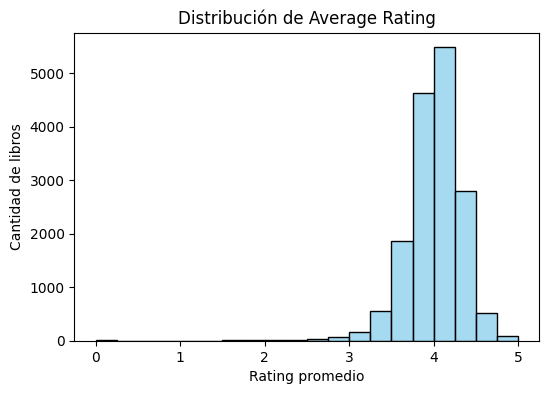

In [4]:
# Distribución de ratings promedio

plt.figure(figsize=(6,4))
sns.histplot(df["average_rating"], bins=20, kde=False, color="skyblue")
plt.title("Distribución de Average Rating")
plt.xlabel("Rating promedio")
plt.ylabel("Cantidad de libros")
plt.show()

- **Observación**: la mayoría de los libros se ubica entre **3.5 y 4.5** estrellas, con un pico alrededor de **~4.0**.  
  Esto confirma el **sesgo positivo** típico de ratings en plataformas de lectura: los usuarios tienden a puntuar alto.


/tmp/ipython-input-3689448526.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genres_df, x="Cantidad", y="Género", palette="viridis")


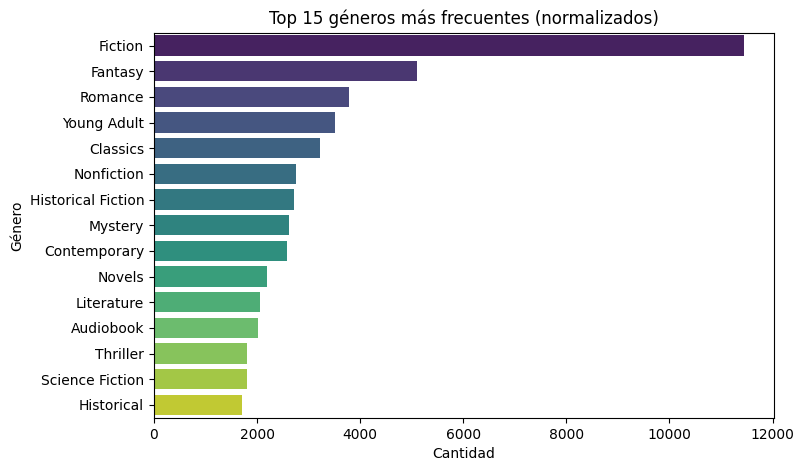

In [7]:
# Top géneros más frecuentes (con normalización)

import ast, re
from collections import Counter

def normalize_genres(cell):
    if pd.isna(cell): return []
    s = str(cell).strip()
    # 1) intentar parsear listas tipo "['Fiction', 'Fantasy']"
    try:
        parsed = ast.literal_eval(s)
        if isinstance(parsed, (list, tuple, set)):
            vals = [str(x) for x in parsed]
        else:
            vals = [s]
    except Exception:
        # 2) si no es lista, separar por separadores comunes
        vals = re.split(r"[,;/|]", s)

    cleaned = []
    for v in vals:
        v = re.sub(r"^[\[\]\(\)'\"`]+|[\[\]\(\)'\"`]+$", "", v.strip())
        if v:
            cleaned.append(v.lower().title())
    return sorted(set(cleaned))

genre_lists = df["genres"].dropna().apply(normalize_genres)
all_genres_clean = [g for sub in genre_lists for g in sub]
genre_counts = Counter(all_genres_clean).most_common(15)

genres_df = pd.DataFrame(genre_counts, columns=["Género", "Cantidad"])
plt.figure(figsize=(8,5))
sns.barplot(data=genres_df, x="Cantidad", y="Género", palette="viridis")
plt.title("Top 15 géneros más frecuentes (normalizados)")
plt.xlabel("Cantidad"); plt.ylabel("Género")
plt.show()


**Nota de limpieza en `genres`.**  
En los datos originales conviven celdas con géneros como texto simple (`Fiction`) y celdas donde el género quedó serializado como **lista en string** (`['Fiction']`).  
Si solo se separa por comas, estas variantes se cuentan como categorías distintas y aparecen duplicados en el gráfico (p. ej., “Fiction” vs “['Fiction']”).  
Se normalizó de la siguiente manera:
1) intentar parsear como lista (`ast.literal_eval`),  
2) si no, partir por separadores comunes (`, ; | /`),  
3) quitar corchetes y comillas residuales,  
4) **Title Case** para unificar mayúsculas/minúsculas,  
5) eliminar duplicados por fila.  
Luego de la normalización, el ranking de géneros ya no duplica etiquetas.


In [8]:
# Ejemplos de sinopsis

print("\n📖 Ejemplo de descripciones (book_details):\n")
for i in range(3):
    print(f"Libro: {df.iloc[i]['book_title']}")
    print(f"Descripción: {df.iloc[i]['book_details'][:300]}...")
    print("="*80)


📖 Ejemplo de descripciones (book_details):

Libro: Harry Potter and the Half-Blood Prince
Descripción: It is the middle of the summer, but there is an unseasonal mist pressing against the windowpanes. Harry Potter is waiting nervously in his bedroom at the Dursleys' house in Privet Drive for a visit from Professor Dumbledore himself. One of the last times he saw the Headmaster, he was in a fierce one...
Libro: Harry Potter and the Order of the Phoenix
Descripción: Harry Potter is about to start his fifth year at Hogwarts School of Witchcraft and Wizardry. Unlike most schoolboys, Harry never enjoys his summer holidays, but this summer is even worse than usual. The Dursleys, of course, are making his life a misery, but even his best friends, Ron and Hermione, s...
Libro: Harry Potter and the Sorcerer's Stone
Descripción: Harry Potter has no idea how famous he is. That's because he's being raised by his miserable aunt and uncle who are terrified Harry will learn that he's really a wizard

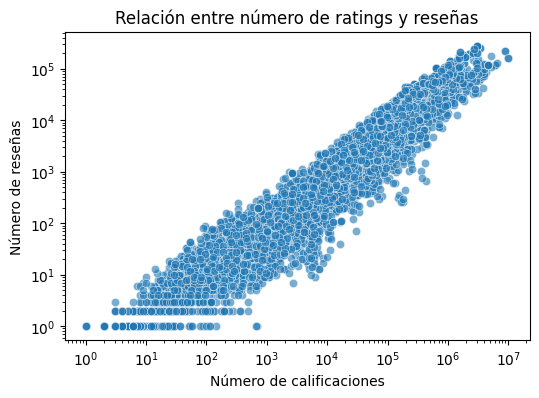

In [9]:
# Popularidad: ratings y reseñas

plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="num_ratings", y="num_reviews", alpha=0.6)
plt.title("Relación entre número de ratings y reseñas")
plt.xlabel("Número de calificaciones")
plt.ylabel("Número de reseñas")
plt.xscale("log")   # log escala porque hay mucha dispersión
plt.yscale("log")
plt.show()

Observaciones

- **Tendencia positiva fuerte:** en escala log–log la nube es casi lineal → a mayor cantidad de **calificaciones**, mayor cantidad de **reseñas**.


### Definición del objetivo (target)

Para transformar el problema en una **clasificación binaria de sentimiento**, utilizamos la variable `average_rating`:

- `sentiment = 1` si `average_rating ≥ 4.0` (libro bien valorado / positivo)  
- `sentiment = 0` si `average_rating < 4.0` (valoración moderada/baja / negativo)

**Decisión:** el umbral en 4 estrellas es un criterio usual en análisis de reseñas para separar percepciones positivas de las neutrales/negativas. Además, permite un dataset balanceado en muchos casos prácticos.


In [10]:
# Nos aseguramos de tener los tipos correctos y sin nulos en las columnas clave
df["average_rating"] = pd.to_numeric(df["average_rating"], errors="coerce")

# Filtramos filas válidas (texto + rating)
df = df.dropna(subset=["book_details", "average_rating"])

# Creamos la variable binaria de sentimiento
# 1 si rating >= 4.0, 0 si rating < 4.0
df["sentiment"] = (df["average_rating"] >= 4.0).astype(int)

# Vista rápida
display(df[["book_title", "book_details", "average_rating", "sentiment"]].head(5))

# Chequeo de balance de clases
print("Distribución de clases (conteo):")
print(df["sentiment"].value_counts())
print("\nDistribución de clases (%) :")
print((df["sentiment"].value_counts(normalize=True) * 100).round(2))


,book_title,book_details,average_rating,sentiment
0,Harry Potter and the Half-Blood Prince,"It is the middle of the summer, but there is a...",4.58,1
1,Harry Potter and the Order of the Phoenix,Harry Potter is about to start his fifth year ...,4.50,1
2,Harry Potter and the Sorcerer's Stone,Harry Potter has no idea how famous he is. Tha...,4.47,1
3,Harry Potter and the Prisoner of Azkaban,"Harry Potter, along with his best friends, Ron...",4.58,1
4,Harry Potter and the Goblet of Fire,It is the summer holidays and soon Harry Potte...,4.57,1


Distribución de clases (conteo):
sentiment
1    8848
0    7329
Name: count, dtype: int64

Distribución de clases (%) :
sentiment
1    54.69
0    45.31
Name: proportion, dtype: float64


### Preprocesamiento (NLP)
**Objetivo:** convertir el texto crudo de `book_details` (sinopsis) en una representación más limpia y útil para modelar.

**Tareas aplicadas:**
1. **Minúsculas**: homogeniza el texto y evita tratar "Love" y "love" como palabras distintas.  
2. **Remoción de puntuación**: elimina signos que no aportan semántica para el objetivo.  
3. **Tokenización**: divide el texto en palabras (tokens).  
4. **Stopwords (inglés) + Lemmatización**:  
   - Stopwords: quita palabras muy frecuentes sin carga semántica (the, and, to, …).  
   - Lemmatización: reduce palabras a su forma base (e.g., *books* → *book*).  
5. **Reconstrucción**: volvemos a unir tokens en un texto limpio para vectorizarlo.

> Decisiones:  
> - Utilización de **stopwords en inglés** porque el dataset de Goodreads está mayormente en inglés.  
> - Preferencia de **lemmatización** (en lugar de stemming) para conservar palabras válidas legibles.


In [11]:
# Preprocesamiento NLP (clean_text)

# Es preprocesamiento NLP que implementa pasos de nivel léxico y morfológico. No hace análisis sintáctico.
#- Léxico: lower, quitar puntuación, tokenización, stopwords (conservando negaciones).
#- Morfológico: POS tagging (para lematizar mejor) + lematización.

import re, string, nltk                  # (utilidades y NLTK)
from nltk.corpus import stopwords        # (stopwords en inglés)
from nltk.stem import WordNetLemmatizer  # (lematizador WordNet)
from nltk import pos_tag                 # (etiquetado POS)

nltk.download('stopwords', quiet=True)   # stopwords de NLTK
nltk.download('wordnet', quiet=True)     # diccionario WordNet
nltk.download('omw-1.4', quiet=True)  # diccionarios extra de wordnet (traducciones/lemmas)

# Tagger: en algunas versiones se llama 'averaged_perceptron_tagger', en otras 'averaged_perceptron_tagger_eng'
for pkg in ['averaged_perceptron_tagger', 'averaged_perceptron_tagger_eng']:
    try:
        nltk.download(pkg, quiet=True)
    except Exception:
        pass

# ---- Recursos ----

# Stopwords EN, preservando negaciones (importante para sentimiento)
stop_words = set(stopwords.words("english")) - {"not", "no", "nor"}

# Lematizador WordNet
lemmatizer = WordNetLemmatizer()

# Opcional: conservar apóstrofes para no romper contracciones (don't -> don't)
punct_re = re.compile(r"[^\w\s']")  # quita todo excepto letras/dígitos/_/espacios/apóstrofe

# Mapa de etiquetas POS de NLTK -> POS de WordNet
def to_wn_pos(tag):
   # J: Adjective -> 'a'; V: Verb -> 'v'; N: Noun -> 'n'; R: Adverb -> 'r'
    return {'J':'a','V':'v','N':'n','R':'r'}.get(tag[0], 'n')

# Función principal de limpieza
def clean_text(s: str) -> str:
    txt = str(s)

  # Minúsculas + limpieza de puntuación (conservar apóstrofes)
    txt = txt.lower()
    txt = punct_re.sub(" ", txt)

    # Tokenización por espacios
    toks = txt.split()

    # Remover stopwords (negaciones se conservaron arriba)
    toks = [t for t in toks if t and t not in stop_words]
    if not toks:
        return ""  # si quedó vacío, devolvemos cadena vacía

    # Etiquetado POS (puede requerir los paquetes del tagger)
    try:
        tags = pos_tag(toks)

    # Lematización informada por POS (mejor que lematizar todo como sustantivo)
        lemmas = [lemmatizer.lemmatize(t, to_wn_pos(p)) for t, p in tags]
    except LookupError:
              # Fallback: si no está disponible el tagger, lematizamos “a secas”
        lemmas = [lemmatizer.lemmatize(t) for t in toks]

    # Reconstrucción del texto limpio
    return " ".join(lemmas)

# --- Aplicación al DataFrame ---
# Aseguramos que haya texto en 'book_details' y creamos la columna 'clean_text'
df = df.dropna(subset=['book_details']).copy()
df['clean_text'] = df['book_details'].astype(str).apply(clean_text)

# Vista rápida antes / después (solo para verificar)
display(df[['book_title', 'book_details', 'clean_text']].head(3))

,book_title,book_details,clean_text
0,Harry Potter and the Half-Blood Prince,"It is the middle of the summer, but there is a...",middle summer unseasonal mist press windowpane...
1,Harry Potter and the Order of the Phoenix,Harry Potter is about to start his fifth year ...,harry potter start fifth year hogwarts school ...
2,Harry Potter and the Sorcerer's Stone,Harry Potter has no idea how famous he is. Tha...,harry potter no idea famous that's raise miser...


#### 🔹 Análisis léxico
- Su objetivo es **dividir el texto en unidades mínimas con significado**, llamadas **tokens** (palabras, signos, números, etc.).  
- En NLP, cuando se aplica **tokenización**, se está realizando análisis léxico.  

**Ejemplo:**  
Texto: "The cats are running."
Tokens: ["The", "cats", "are", "running", "."]


#### Métricas léxicas
- **Tokens** totales y **tipos** (vocabulario único).  
- **Type–Token Ratio (TTR)** = tipos / tokens (riqueza léxica).  
- **Hapax legomena**: proporción de palabras que aparecen solo 1 vez.  
- **Longitud media de palabra** y distribución de longitudes.  
- **Proporción de stopwords** sobre el total de tokens.

In [15]:
# Análisis léxico del corpus (TODAS las sinopsis)
# - Usa book_details crudo (sin lematizar) para no perder morfología
# - Calcula: tokens totales, vocabulario, TTR, hapax, % stopwords,
#            longitud media de palabra y TTR por documento (media/mediana)


# Recursos NLTK
for pkg in ["stopwords"]:
    try:
        nltk.download(pkg, quiet=True)
    except Exception:
        pass

# Preparación
stop_en = set(stopwords.words("english"))
punct_re = re.compile(f"[{re.escape(string.punctuation)}]")

def basic_tokenize(s: str):
    s = s.lower()
    s = punct_re.sub(" ", s)
    return [t for t in s.split() if t]  # tokens por espacios, sin vacíos

# Tomar TODO el corpus (sin muestras)
texts_all = df["book_details"].dropna().astype(str).tolist()
texts = texts_all  # <<< usa todas las sinopsis >>>

# Acumuladores
total_tokens = 0
sum_word_len = 0
stop_count = 0
freq = collections.Counter()
doc_ttrs = []

# Recorrido del corpus completo
for s in texts:
    toks = basic_tokenize(s)
    if not toks:
        continue
    total_tokens += len(toks)
    sum_word_len += sum(len(w) for w in toks)
    stop_count += sum(1 for w in toks if w in stop_en)
    freq.update(toks)
    doc_ttrs.append(len(set(toks)) / len(toks))  # TTR por documento

# Métricas
vocab_size = len(freq)
hapax_ratio = (sum(1 for _, c in freq.items() if c == 1) / vocab_size) if vocab_size else 0.0
ttr_corpus = (vocab_size / total_tokens) if total_tokens else 0.0
avg_word_len = (sum_word_len / total_tokens) if total_tokens else 0.0
stop_ratio = (stop_count / total_tokens) if total_tokens else 0.0
ttr_doc_mean = float(np.mean(doc_ttrs)) if doc_ttrs else 0.0
ttr_doc_median = float(np.median(doc_ttrs)) if doc_ttrs else 0.0

# Resumen en DataFrame
lexical_summary = pd.DataFrame({
    "docs_analizados": [len(texts)],
    "tokens_totales": [total_tokens],
    "tipos_vocab": [vocab_size],
    "TTR_corpus": [round(ttr_corpus, 4)],
    "hapax_ratio": [round(hapax_ratio, 4)],
    "longitud_media_palabra": [round(avg_word_len, 3)],
    "prop_stopwords": [round(stop_ratio, 4)],
    "TTR_doc_media": [round(ttr_doc_mean, 4)],
    "TTR_doc_mediana": [round(ttr_doc_median, 4)],
})

display(lexical_summary)



,docs_analizados,tokens_totales,tipos_vocab,TTR_corpus,hapax_ratio,longitud_media_palabra,prop_stopwords,TTR_doc_media,TTR_doc_mediana
0,16177,2450507,112670,0.046,0.5633,4.729,0.428,0.7101,0.7


Resumen del análisis léxico (corpus completo)

Referencias:
- **TTR_corpus** (tipos/tokens) y **TTR_doc_media** indican **riqueza léxica**; valores más altos → vocabulario más variado.
- **hapax_ratio** refleja cuántas palabras aparecen **una sola vez** (rareza / ruido).
- **prop_stopwords** mide el peso de palabras funcionales; justifica quitar stopwords en el preprocesamiento.
- **longitud_media_palabra** es un proxy de **complejidad léxica**.

Resultados:
- **docs_analizados:** 16.177 sinopsis.
- **tokens_totales:** 2.450.507 palabras procesadas.
- **tipos_vocab (vocabulario único):** 112.670 términos → corpus variado.
- **TTR_corpus = 0,046:** proporción tipos/tokens baja (normal en corpora grandes: muchas repeticiones).
- **hapax_ratio = 0,5633:** ~56% del vocabulario aparece una sola vez (larga cola de términos raros/únicos).
- **longitud_media_palabra = 4,729:** longitud típica para prosa en inglés.
- **prop_stopwords = 0,428:** ~43% de tokens son stopwords → justifica removerlas en el preprocesamiento.
- **TTR_doc_media = 0,7101 (mediana 0,70):** dentro de cada sinopsis hay alta diversidad relativa (los textos son relativamente cortos, sube el TTR por documento).

**Conclusión:** El corpus es amplio y heterogéneo, con muchas palabras raras y gran presencia de stopwords. Esto respalda el pipeline usado: limpieza + eliminación de stopwords + lematización y vectorización **TF-IDF** (con umbrales `min_df`/`max_df`) para reducir ruido y resaltar términos informativos.


In [18]:
# Distribución de longitud de palabra (léxico) usando train

#Este histograma de longitudes de palabra se calcula sobre el **conjunto de entrenamiento** para evitar *data leakage*.
#verifica que el texto esté sano (pico 4–7 letras, típico en inglés) y alerta sobre extremos (min=1, max≈53)

texts = df["clean_text"].astype(str)
labels = df["sentiment"].values

X_train_txt, X_test_txt, y_train_txt, y_test_txt = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)


,valor
tokens_totales,1.141088e+06
longitud_media,5.763551e+00
mediana,5.000000e+00
p10,3.000000e+00
p25,4.000000e+00
p75,7.000000e+00
p90,9.000000e+00
min,1.000000e+00
max,5.300000e+01


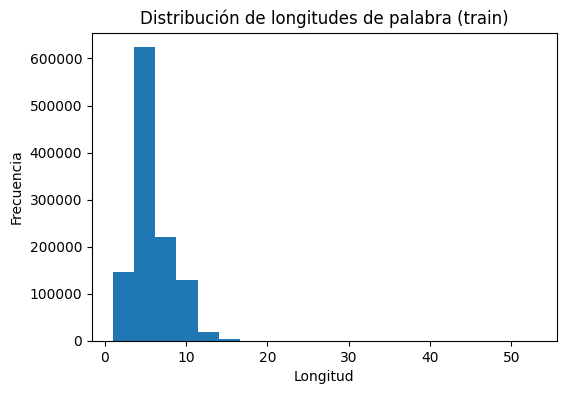

In [19]:
from nltk.corpus import stopwords
stop_en = set(stopwords.words('english'))

def simple_tokens(s):
    s = re.sub(f"[{re.escape(string.punctuation)}]", " ", s.lower())
    return [t for t in s.split() if t]

tokens = []
for s in X_train_txt:
    tokens.extend([w for w in simple_tokens(s)])

import numpy as np, pandas as pd, matplotlib.pyplot as plt
lengths = np.array([len(w) for w in tokens])
summary = pd.Series({
    "tokens_totales": len(tokens),
    "longitud_media": lengths.mean(),
    "mediana": np.median(lengths),
    "p10": np.percentile(lengths, 10),
    "p25": np.percentile(lengths, 25),
    "p75": np.percentile(lengths, 75),
    "p90": np.percentile(lengths, 90),
    "min": lengths.min(),
    "max": lengths.max(),
})
display(summary.to_frame("valor"))
plt.figure(figsize=(6,4))
plt.hist(lengths, bins=20)
plt.title("Distribución de longitudes de palabra (train)")
plt.xlabel("Longitud"); plt.ylabel("Frecuencia")
plt.show()


Longitud de palabras (train) — interpretación

- **tokens_totales ≈ 1.14 M**: cantidad de palabras analizadas en el split de entrenamiento.
- **longitud_media ≈ 5.76** y **mediana = 5**: la mayor parte de las palabras tiene **5–6** caracteres (típico en inglés).
- **p10 = 3 · p25 = 4 · p75 = 7 · p90 = 9**: el **50% central** cae entre **4 y 7**; el 90% está por debajo de **9**.
- **min = 1**: tokens de 1 carácter (p. ej., “a”, “I”) o ruido.
- **max = 53**: tokens muy largos; suelen ser números, URLs, identificadores o palabras compuestas—si molestan, podés filtrarlos.

**histograma:** la masa está entre **3 y 10** caracteres; es una distribución razonable para prosa.  


#### 🔹 Análisis morfológico
- Actúa sobre los tokens ya identificados.  
- Estudia la **forma de las palabras** (raíces, sufijos, conjugaciones).  
- En la práctica se implementa con **lemmatización** o **stemming**.  

**Ejemplo:**  
running → run
ran → run
runs → run

#### Métricas morfológicas / gramaticales
- **Etiquetado POS** (*Part-of-Speech*): sustantivos, verbos, adjetivos, adverbios, etc.  
- **Lemas más frecuentes** por POS (ej: sustantivos y adjetivos).  
- (Opcional) **Rasgos morfológicos** adicionales según el modelo (género, número, tiempo, persona).  


,POS,Cantidad,Porcentaje
0,NOUN,743003,30.320379
1,VERB,405483,16.546902
2,ADP,287511,11.732715
3,DET,272115,11.104437
4,ADJ,266915,10.892236
5,PRON,153505,6.264214
6,ADV,114999,4.692866
7,CONJ,101123,4.126615
8,PRT,67952,2.772977
9,NUM,29349,1.197671


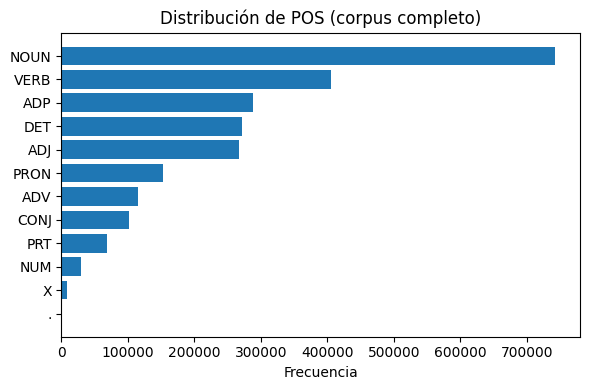

In [20]:
# POS en TODO el corpus (rápido con batches)
import nltk, re, string, collections, pandas as pd, matplotlib.pyplot as plt
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
nltk.download('universal_tagset', quiet=True)

def simple_tokens(s: str):
    s = s.lower()
    s = re.sub(f"[{re.escape(string.punctuation)}]", " ", s)
    return [t for t in s.split() if t]

texts = df["book_details"].dropna().astype(str).tolist()

def token_batches(texts, batch_size=512):
    batch = []
    for s in texts:
        toks = simple_tokens(s)
        if toks:
            batch.append(toks)
        if len(batch) == batch_size:
            yield batch
            batch = []
    if batch:
        yield batch

pos_counts = collections.Counter()

for batch in token_batches(texts, batch_size=512):
    # etiqueta listas de tokens en lote (universal tagset: NOUN, VERB, ADJ, …)
    tagged_sents = nltk.pos_tag_sents(batch, tagset='universal')
    for sent in tagged_sents:
        for _, pos in sent:
            pos_counts[pos] += 1

pos_df = pd.DataFrame(pos_counts.most_common(), columns=["POS","Cantidad"])
pos_df["Porcentaje"] = 100 * pos_df["Cantidad"] / pos_df["Cantidad"].sum()
display(pos_df)

# (Opcional) gráfico
plt.figure(figsize=(6,4))
plt.barh(pos_df["POS"], pos_df["Cantidad"])
plt.gca().invert_yaxis()
plt.title("Distribución de POS (corpus completo)")
plt.xlabel("Frecuencia")
plt.tight_layout()
plt.show()


Distribución de POS

- **NOUN (30.3%)** y **VERB (16.5%)** dominan → muchas **entidades/temas** y **acciones**: típico de sinopsis.
- **ADP (11.7%)** (*in, on, at…*) y **DET (11.1%)** (*the, a…*) son **palabras funcionales** de enlace; su presencia alta es normal en inglés.
- **ADJ (10.9%)** y **ADV (4.7%)** indican fuerte **componente descriptivo** (adjetivos) y matices (adverbios), otra señal coherente con sinopsis.
- **PRON (6.3%)**, **CONJ (4.1%)**, **PRT (2.8%)** en niveles esperables.
- **NUM (1.2%)**: pocos números; razonable para narrativa.
- **X (0.34%)**: tokens “desconocidos/otros” (restos de URLs, símbolos, emojis).  
- **"." (~0%)**: algo de puntuación se coló; irrelevante para el análisis.

**Conclusión rápida.** El perfil POS es el esperado para texto narrativo/descriptivo. La mezcla de **palabras de contenido** (NOUN+VERB+ADJ+ADV ≈ **62%**) y **funcionales** (ADP+DET+PRON+CONJ+PRT ≈ **36%**) justifica:
- **remover stopwords** (muchas caen en ADP/DET/CONJ/PRON),  
- **lematizar** (por la alta proporción de NOUN/VERB/ADJ),  
- y representar con **TF-IDF**.




#### 🔹 Análisis sintáctico
- Examina cómo se **relacionan los tokens entre sí** para formar oraciones.  
- Busca la **estructura gramatical**: sujeto, verbo, objeto, modificadores y dependencias.  

**Ejemplo:**  
"The cats are running."
→ Sujeto: "cats"
→ Verbo: "running"
→ Modificador: (ninguno explícito)

#### Técnicas asociadas
- **Dependency parsing**: relaciones entre palabras en un grafo dirigido.  
- **Constituency parsing**: agrupación en sintagmas (SN, SV, etc.).  
- **POS tagging** (ya visto en análisis morfológico) como insumo básico.  

---
  


#### 🔹 Niveles adicionales (opcional, más avanzados)
- **Análisis semántico** → significado de las palabras en contexto.  
  - Ej: *“banco”* = institución financiera vs asiento.  
- **Análisis pragmático** → interpretación según el contexto de uso.  
  - Ej: *“¿Podés abrir la ventana?”* = pedido, no pregunta literal.

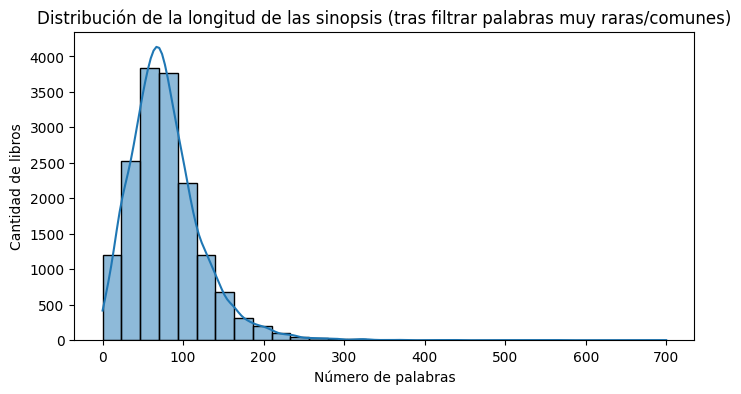

In [21]:
# Este código filtra (en una copia), elimina palabras muy raras y demasiado comunes, reconstruye el texto filtrado y grafica cuántas palabras “útiles” quedan por sinopsis.

from collections import Counter

# Partimos de la columna limpia
assert "clean_text" in df.columns
df_fil = df.copy()
df_fil["tokens"] = df_fil["clean_text"].str.split()

# Frecuencia de documento: en cuántos documentos aparece cada palabra
doc_freq = Counter()
for toks in df_fil["tokens"]:
    doc_freq.update(set(toks))  # set() para contar cada palabra una sola vez por doc

min_df = 5                  # palabra debe aparecer al menos en 5 documentos
max_df_ratio = 0.5          # y en como mucho el 50% de los documentos
max_df = int(max_df_ratio * len(df_fil))

def keep_mid_freq(tokens):
    return [w for w in tokens if (doc_freq[w] >= min_df and doc_freq[w] <= max_df)]

df_fil["final_tokens"] = df_fil["tokens"].apply(keep_mid_freq)
df_fil["final_review"] = df_fil["final_tokens"].str.join(" ")

# Longitud (número de palabras) tras el filtrado
df_fil["review_length"] = df_fil["final_tokens"].apply(len)

plt.figure(figsize=(8,4))
sns.histplot(df_fil["review_length"], bins=30, kde=True)
plt.title("Distribución de la longitud de las sinopsis (tras filtrar palabras muy raras/comunes)")
plt.xlabel("Número de palabras"); plt.ylabel("Cantidad de libros")
plt.show()


Preprocesamiento avanzado: selección de vocabulario por DF

**Qué hicimos**
- Calculamos la **frecuencia de documento (DF)** de cada palabra (en cuántas sinopsis aparece).
- Nos quedamos solo con términos “informativos”, filtrando:
  - **muy raros**: `DF < 5` (posibles typos/nombres únicos),
  - **demasiado comunes**: `DF > 50%` de los documentos (pocas pistas discriminantes).
- Para cada sinopsis contamos las palabras que **sobreviven** al filtro → `review_length`.

**Qué muestra el histograma**
- La **distribución de longitudes** de las sinopsis **después** del filtrado DF.
- Se ve una forma **asimétrica a la derecha** (cola larga): la mayoría de los textos queda entre **~40 y ~120** palabras “útiles”, con algunos casos largos (outliers hasta >300).
- El pico alrededor de **~60–90** sugiere que, tras eliminar ruido y términos triviales, la **masa de información útil** por sinopsis es relativamente acotada.

**Para qué sirve**
- **Reduce dimensionalidad** y **ruido** antes de vectorizar.
- Hace el vocabulario más **discriminante** para el modelo.
- Te orienta sobre tamaños razonables si luego usás modelos secuenciales (p. ej., fijar una **longitud máxima** ≈ 150–200).
- Este mismo criterio se aplica de forma más limpia **directamente en TF-IDF** con `min_df=5` y `max_df=0.5` (evitás filtrar dos veces).

> En síntesis: el gráfico confirma que el filtrado por DF conserva la “parte útil” del texto y estabiliza la longitud efectiva de las sinopsis, lo que ayuda a **generalizar** mejor en el modelado.


### Preprocesamiento avanzado: n-gramas

In [23]:
#Top bigramas (conteo total) usando texto limpio y filtrando stopwords- frecuencia total de bigramas “de contenido”

assert "clean_text" in df.columns, "Primero crea df['clean_text']"
texts = df["clean_text"].astype(str)

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np, pandas as pd

vectorizer = CountVectorizer(
    ngram_range=(2,2),
    min_df=5,          # elimina bigramas rarísimos
    max_df=0.5,        # elimina bigramas demasiado comunes
    stop_words='english',                # quita stopwords
    token_pattern=r'(?u)\b[a-z]{3,}\b'   # solo tokens alfabéticos de ≥3 letras
)
X_2g = vectorizer.fit_transform(texts)

freqs = np.asarray(X_2g.sum(axis=0)).ravel()  # # de apariciones en todo el corpus
bigrams = (
    pd.DataFrame({"bigram": vectorizer.get_feature_names_out(), "freq": freqs})
      .sort_values("freq", ascending=False)
      .head(20)
)
display(bigrams)


,bigram,freq
10439,new york,1811
17319,year old,1369
17368,york time,1051
1086,bestselling author,664
15070,time bestselling,558
1048,best friend,547
13525,short story,511
17110,world war,487
17249,year ago,403
17442,young woman,390


In [24]:
# Documento-frecuencia (cuántos documentos contienen el bigrama)
assert "clean_text" in df.columns
texts = df["clean_text"].astype(str)

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np, pandas as pd

vectorizer = CountVectorizer(
    ngram_range=(2,2),
    min_df=5,
    max_df=0.5,
    stop_words='english',
    token_pattern=r'(?u)\b[a-z]{3,}\b',
    binary=True         # <-- CUENTA presencia por documento
)
X_2g = vectorizer.fit_transform(texts)

docfreq = np.asarray(X_2g.sum(axis=0)).ravel()  # # de documentos
bigrams_df = (
    pd.DataFrame({"bigram": vectorizer.get_feature_names_out(), "doc_freq": docfreq})
      .sort_values("doc_freq", ascending=False)
      .head(20)
)
display(bigrams_df)


,bigram,doc_freq
10439,new york,1551
17319,year old,1272
17368,york time,976
1086,bestselling author,632
15070,time bestselling,533
1048,best friend,486
17110,world war,433
17249,year ago,379
14760,tell story,368
706,award win,364


### Preprocesamiento avanzado: Análisis lingüístico-Análisis léxico -Visualizaciones (nube de palabras)

In [25]:
# Nube de Palabras

#visualización exploratoria donde el tamaño de cada término refleja su frecuencia (o peso) en un conjunto de textos.

!pip -q install wordcloud
from wordcloud import WordCloud


In [27]:
# Elegimos la columna de texto limpia disponible
text_col = "final_review" if "final_review" in df.columns else "clean_text"
assert text_col in df.columns, "No encuentro ni 'final_review' ni 'clean_text'. Ejecutá el preprocesamiento."

# Definimos umbrales (ajustables)
# positivo: rating >= 4.0 | neutral: [3.0, 4.0) | negativo: < 3.0
pos_mask = df["average_rating"] >= 4.0
neu_mask = (df["average_rating"] >= 3.0) & (df["average_rating"] < 4.0)
neg_mask = df["average_rating"] < 3.0

# Concatenamos textos por grupo
positive_text = " ".join(df.loc[pos_mask, text_col].dropna().astype(str))
neutral_text  = " ".join(df.loc[neu_mask, text_col].dropna().astype(str))
negative_text = " ".join(df.loc[neg_mask, text_col].dropna().astype(str))

# Conteo para referencia
print("Docs positivos:", pos_mask.sum(),
      "| neutrales:", neu_mask.sum(),
      "| negativos:", neg_mask.sum())


Docs positivos: 8848 | neutrales: 7193 | negativos: 136


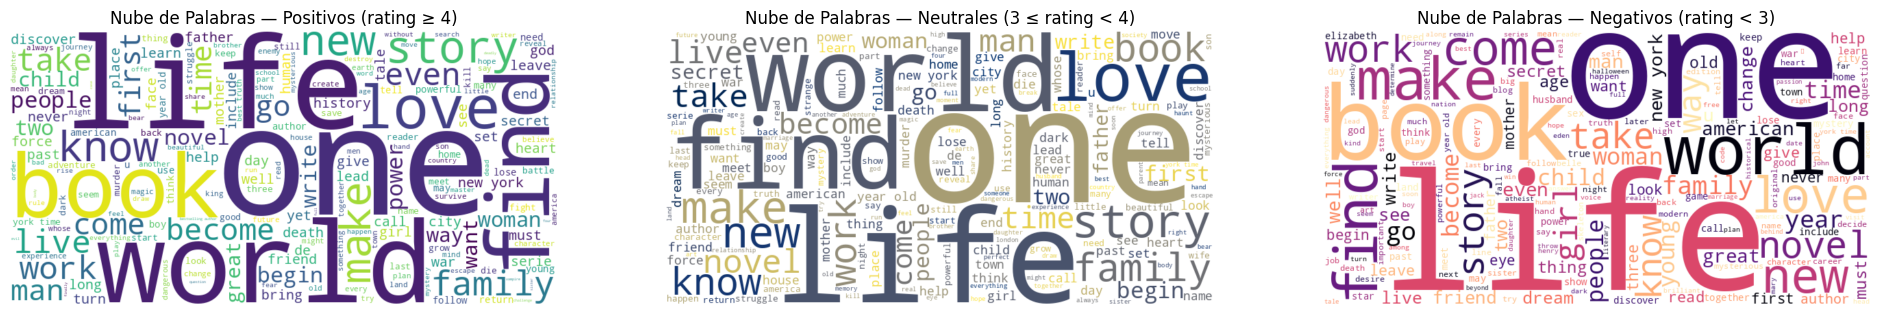

In [28]:
clouds = []
titles = []

if len(positive_text) > 0:
    clouds.append(WordCloud(width=800, height=400, background_color="white",
                            colormap="viridis").generate(positive_text))
    titles.append("Nube de Palabras — Positivos (rating ≥ 4)")

if len(neutral_text) > 0:
    clouds.append(WordCloud(width=800, height=400, background_color="white",
                            colormap="cividis").generate(neutral_text))
    titles.append("Nube de Palabras — Neutrales (3 ≤ rating < 4)")

if len(negative_text) > 0:
    clouds.append(WordCloud(width=800, height=400, background_color="white",
                            colormap="magma").generate(negative_text))
    titles.append("Nube de Palabras — Negativos (rating < 3)")

# Mostrar dinámicamente las nubes disponibles
n = len(clouds)
if n == 0:
    print("No hay texto para generar nubes. Revisá los umbrales o la columna de texto.")
else:
    plt.figure(figsize=(8*n, 4))
    for i, wc in enumerate(clouds, 1):
        plt.subplot(1, n, i)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(titles[i-1])
    plt.show()


### Preprocesamiento avanzado - Análisis lingüístico - Sintaxis.

In [29]:
import spacy, numpy as np, sys, subprocess

print("numpy:", np.__version__)  # debería ser 1.x si instalaste numpy<2

try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    # descargar el modelo si no está
    subprocess.run([sys.executable, "-m", "spacy", "download", "en_core_web_sm"], check=True)
    nlp = spacy.load("en_core_web_sm")


numpy: 2.0.2


In [31]:
from spacy import displacy

# Tomamos los textos crudos (mejor para análisis sintáctico)
texts = df["book_details"].dropna().astype(str)

# Elegí 1 de longitud moderada (evita árboles enormes)
lens = texts.str.len()
idx = lens.sort_values().index[len(lens)//2]  # mediana de longitudes
doc = nlp(texts.loc[idx])                     # ⚠️ parsea SOLO este texto

options = {"compact": True, "bg": "#fafafa", "color": "#000", "font": "Arial", "distance": 80}
displacy.render(doc, style="dep", jupyter=True, options=options)


In [32]:
# 2–3 textos “razonables”
sel = texts[lens.between(300, 700)].sample(3, random_state=42)
for doc in nlp.pipe(sel.tolist(), batch_size=32):
    displacy.render(doc, style="dep", jupyter=True, options=options)


### Vectorización (TF‑IDF)

**Objetivo:** transformar el texto en números para poder entrenar modelos.

Usamos **TF‑IDF** (*Term Frequency–Inverse Document Frequency*), que pondera cada palabra según:
- su frecuencia dentro del documento (*TF*), y
- qué tan exclusiva es respecto del corpus completo (*IDF*).

**Parámetros clave:**
- `max_features = 5000`: limita el vocabulario a las 5.000 palabras más informativas para controlar la dimensionalidad y el tiempo de cómputo.

**Salida:** una matriz de tamaño *(n_muestras × n_palabras)* con pesos TF‑IDF, lista para modelos de ML/DL.

**Alternativas consideradas:** Bag‑of‑Words, embeddings (Word2Vec/GloVe) o tokenización Keras + capa `Embedding`.  
Se elige TF‑IDF por **simplicidad** y **rapidez** para esta entrega.



In [33]:
# ===== Vectorización y Split (sin leakage) =====

SEED = 42

texts = df['clean_text'].astype(str)
labels = df['sentiment'].astype(int).values

from sklearn.model_selection import train_test_split
X_train_txt, X_test_txt, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=SEED
)
print("Train/Test docs:", len(X_train_txt), len(X_test_txt))

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

VEC_PARAMS = dict(
    max_features=5000,
    min_df=5,
    max_df=0.5,                 # proporción (50% de los docs)
    ngram_range=(1,1),
    sublinear_tf=True,          # tf -> 1 + log(tf)
    token_pattern=r'(?u)\b[a-z]{3,}\b',  # solo letras, >=3 chars
    dtype=np.float32
)
tfidf = TfidfVectorizer(**VEC_PARAMS)

# Fit SOLO en train; transform en test
X_train_sparse = tfidf.fit_transform(X_train_txt)
X_test_sparse  = tfidf.transform(X_test_txt)

# Para Keras (Dense) necesitamos denso
X_train = X_train_sparse.toarray()
X_test  = X_test_sparse.toarray()

print("Shapes:", X_train.shape, X_test.shape)


Train/Test docs: 12941 3236
Shapes: (12941, 5000) (3236, 5000)


In [34]:
from collections import Counter

# y_train y y_test ya existen del train_test_split
def resumen_clases(y, nombre):
    cnt = Counter(y)
    total = len(y)
    c0 = cnt.get(0, 0); c1 = cnt.get(1, 0)
    p0 = 100*c0/total if total else 0
    p1 = 100*c1/total if total else 0
    print(f"{nombre}: total={total} | Clase 0={c0} ({p0:.1f}%) | Clase 1={c1} ({p1:.1f}%)")

resumen_clases(y_train, "y_train")
resumen_clases(y_test,  "y_test")

y_train: total=12941 | Clase 0=5863 (45.3%) | Clase 1=7078 (54.7%)
y_test: total=3236 | Clase 0=1466 (45.3%) | Clase 1=1770 (54.7%)


Interpretación de los resultados

La vectorización TF-IDF y la partición *train/test* arrojaron los siguientes resultados:

- **Shape X_train: (12941, 5000)**  
  - El set de entrenamiento contiene **12.941 libros**.  
  - Cada libro está representado por **5.000 features TF-IDF**, correspondientes a las palabras más informativas del corpus.  

- **Shape X_test: (3236, 5000)**  
  - El set de prueba contiene **3.236 libros**, también con 5.000 características cada uno.  

Distribución de clases (train/test)

- **y_train:** 12.941 muestras → Clase 0 = 5.863 (**45,3%**), Clase 1 = 7.078 (**54,7%**)
- **y_test:** 3.236 muestras → Clase 0 = 1.466 (**45,3%**), Clase 1 = 1.770 (**54,7%**)

**Lectura:** el split quedó **estratificado** (misma proporción en train y test).  
El dataset está **moderadamente balanceado** (≈45/55), por lo que:
- no es imprescindible usar `class_weight`/SMOTE,
- una baseline “siempre Clase 1” tendría ~**54,7%** de accuracy (útil como referencia),
- conviene reportar **precision/recall/F1** además de accuracy.



## Modelo base (Red Neuronal simple)

**Arquitectura (Keras Sequential):**
- `Dense(64, relu)` con `input_dim = dimensión TF‑IDF`
- `Dense(1, sigmoid)` como capa de salida (probabilidad de clase positiva)

**Entrenamiento:**
- Pérdida: `binary_crossentropy`
- Optimizador: `adam`
- Métrica: `accuracy`
- Validación interna: `validation_split = 0.2`
- Épocas: `5` (valor inicial para un baseline rápido)
- Batch size: `32`

> Este modelo cumple el **mínimo requerido de Deep Learning**.  
> El objetivo es establecer un **baseline** sobre el cual comparar la versión mejorada.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
324/324 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5623 - loss: 0.6764 - val_accuracy: 0.6474 - val_loss: 0.6342
Epoch 2/5
324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7164 - loss: 0.5669 - val_accuracy: 0.6319 - val_loss: 0.6483
Epoch 3/5
324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7691 - loss: 0.4862 - val_accuracy: 0.6211 - val_loss: 0.6984
Epoch 4/5
324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7962 - loss: 0.4334 - val_accuracy: 0.6095 - val_loss: 0.7589
Epoch 5/5
324/324 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8176 - loss: 0.3914 - val_accuracy: 0.6033 - val_loss: 0.8259
               precision    recall  f1-score   support

 negativo(<4)       0.55      0.57      0.56      1466
positivo(>=4)       0.63      0.61      0.62      1770

     accuracy                           0.59      3236
    macro avg       0.59      0.59      0.59      3236
 weighted avg       0.59      0.59      0.59      3236



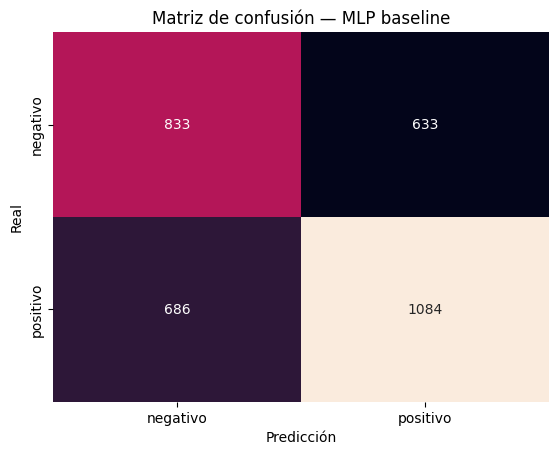

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

tf.random.set_seed(42)

# Asegura que X_train, X_test, y_train, y_test existen (TF-IDF listo)
assert 'X_train' in globals() and 'y_train' in globals()
assert 'X_test' in globals() and 'y_test' in globals()

# === MLP baseline ===
model_base = Sequential([
    Dense(64, activation="relu", input_dim=X_train.shape[1]),
    Dense(1, activation="sigmoid")
])

model_base.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

hist_base = model_base.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=5, batch_size=32, verbose=1
)

# Predicciones baseline (umbral 0.5)
y_pred_base = (model_base.predict(X_test, verbose=0).ravel() >= 0.5).astype(int)

# Reporte y matriz de confusión
print(classification_report(y_test, y_pred_base, target_names=["negativo(<4)", "positivo(>=4)"]))

cm = confusion_matrix(y_test, y_pred_base)
sns.heatmap(cm, annot=True, fmt="d", cbar=False,
            xticklabels=["negativo","positivo"],
            yticklabels=["negativo","positivo"])
plt.title("Matriz de confusión — MLP baseline"); plt.xlabel("Predicción"); plt.ylabel("Real")
plt.show()


Lectura del baseline (MLP)
- **Accuracy = 0.59** → supera la baseline trivial “siempre Clase 1” (~0.547) por ~4.3 pp, pero aún es modesto.
- **Por clase**
  - Negativa: recall = 0.57 (833/1466), precision ≈ 0.55 → confunde 633 negativos como positivos (FP).
  - Positiva: recall = 0.61 (1084/1770), precision ≈ 0.63 → confunde 686 positivos como negativos (FN).
- **Matriz de confusión**: errores de ambos tipos en torno a ~650 cada uno → el umbral 0.5 no es óptimo.
- **Conclusión**: baseline razonable, pero hay espacio claro de mejora.


### Modelo mejorado (regularización + callbacks)

**Motivación :**  
Se observó **overfitting**: `train loss ↓` mientras `val loss ↑` y `val acc ↓`.  
Para mitigarlo, mejoramos la red agregando **capacidad controlada** y **regularización**.

**Arquitectura propuesta (Keras Sequential):**
- `Dense(128, relu, kernel_regularizer=L2(1e-4))`
- `Dropout(0.5)`
- `Dense(64, relu, kernel_regularizer=L2(1e-4))`
- `Dropout(0.5)`
- `Dense(1, sigmoid)`  
> Aumentamos ligeramente la capacidad (más neuronas) pero **forzamos generalización** con *L2* y *Dropout*.

**Por qué estas técnicas:**
- **L2 (weight decay)**: penaliza pesos grandes → reduce varianza y sobreajuste.
- **Dropout**: apaga aleatoriamente neuronas durante el entrenamiento → evita co-adaptaciones y mejora la robustez.
- **EarlyStopping**: detiene cuando la validación deja de mejorar → previene entrenar “de más”.
- **ReduceLROnPlateau**: baja la tasa de aprendizaje si `val_loss` se estanca → facilita convergencia fina.

**Entrenamiento y configuración:**
- Optimizador: `Adam(learning_rate=1e-3)`
- Pérdida: `binary_crossentropy`
- Métrica: `accuracy`
- `epochs=25` con `EarlyStopping(patience=3, re


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5357 - loss: 0.7104 - val_accuracy: 0.6192 - val_loss: 0.6731 - learning_rate: 0.0010
Epoch 2/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6663 - loss: 0.6439 - val_accuracy: 0.6277 - val_loss: 0.6988 - learning_rate: 0.0010
Epoch 3/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7420 - loss: 0.5680 - val_accuracy: 0.6153 - val_loss: 0.7590 - learning_rate: 0.0010
Epoch 4/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8109 - loss: 0.4866 - val_accuracy: 0.6083 - val_loss: 0.8353 - learning_rate: 5.0000e-04
Umbral óptimo (validación) ≈ 0.463 | F1_val=0.712
== Reporte (modelo mejorado, umbral validación) en Test ==
               precision    recall  f1-score   support

 negativo(<4)       0.66      0.20      0.31      1466
positivo(>=4)       0.58      0.91      0.71      1770

     accuracy                           0.59      3236
    macro avg       0.62      0.56      0.51      323

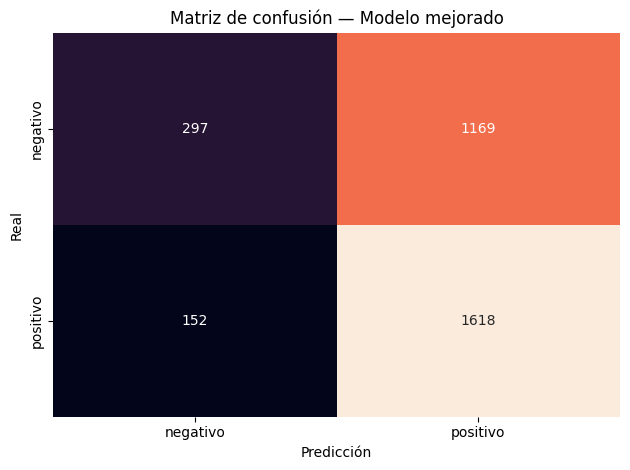

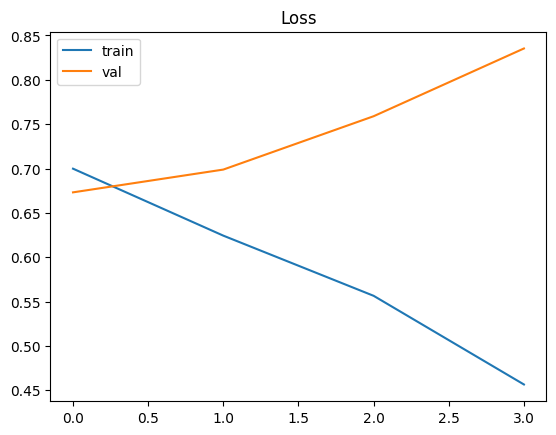

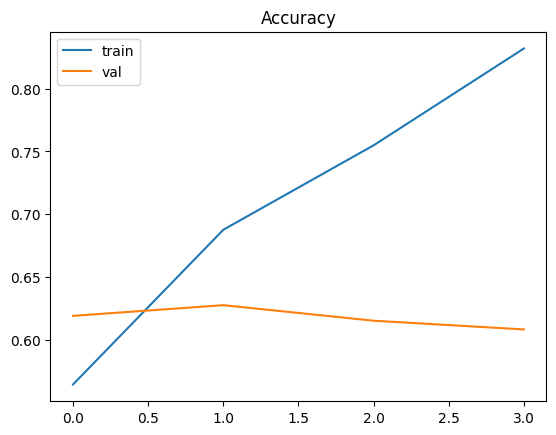

In [38]:
# --- Split explícito train/valid (del train original) ---
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

tf.random.set_seed(42)

model2 = Sequential([
    Dense(128, activation="relu", input_dim=X_tr.shape[1],
          kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.5),
    Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
               loss="binary_crossentropy", metrics=["accuracy"])

callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5)
]

hist2 = model2.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=25, batch_size=64,
    callbacks=callbacks, verbose=1
)

# --- Elegir UMBRAL con VALIDACIÓN (no con test) ---
from sklearn.metrics import precision_recall_curve, f1_score, classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

val_proba = model2.predict(X_val, verbose=0).ravel()
prec, rec, thr = precision_recall_curve(y_val, val_proba)
f1 = 2*prec*rec/(prec+rec+1e-12)
best_idx = np.argmax(f1)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print(f"Umbral óptimo (validación) ≈ {best_thr:.3f} | F1_val={f1[best_idx]:.3f}")

# --- Evaluación FINAL en TEST con ese umbral ---
test_proba = model2.predict(X_test, verbose=0).ravel()
y_pred2 = (test_proba >= best_thr).astype(int)

print("== Reporte (modelo mejorado, umbral validación) en Test ==")
print(classification_report(y_test, y_pred2, target_names=["negativo(<4)","positivo(>=4)"]))

cm2 = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm2, annot=True, fmt="d", cbar=False,
            xticklabels=["negativo","positivo"], yticklabels=["negativo","positivo"])
plt.title("Matriz de confusión — Modelo mejorado")
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.tight_layout(); plt.show()

# Curvas de entrenamiento (opcional)
h2 = hist2.history
plt.figure(); plt.plot(h2["loss"], label="train"); plt.plot(h2["val_loss"], label="val"); plt.legend(); plt.title("Loss"); plt.show()
plt.figure(); plt.plot(h2["accuracy"], label="train"); plt.plot(h2["val_accuracy"], label="val"); plt.legend(); plt.title("Accuracy"); plt.show()



Interpretación del Modelo mejorado

Accuracy 0.59 (igual que el baseline) pero:

Recall clase 0 (negativo) = 0.20 → el modelo casi no detecta negativos.

Recall clase 1 (positivo) = 0.91 → predice “positivo” la mayor parte del tiempo.

La matriz de confusión tiene muchos falsos positivos (1169).
⇒ El umbral quedó demasiado bajo para tu criterio de evaluación.

Curvas train vs val: loss de validación sube y accuracy de validación se aplana → overfitting (el modelo aprende train, pero no generaliza).

En resumen: el “modelo mejorado” favorece mucho la clase positiva (alta sensibilidad) y sacrifica la negativa.

Umbral por macro-F1 (val): 0.560 | macro-F1_val=0.708
Umbral por balanced acc (val): 0.560 | bAcc_val=0.711
== Reporte (modelo mejorado con umbral validación) en Test ==
               precision    recall  f1-score   support

 negativo(<4)       0.56      0.64      0.60      1466
positivo(>=4)       0.66      0.59      0.62      1770

     accuracy                           0.61      3236
    macro avg       0.61      0.61      0.61      3236
 weighted avg       0.62      0.61      0.61      3236



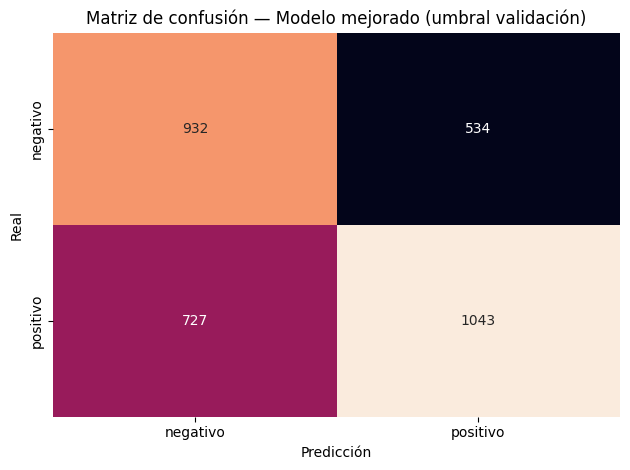

In [39]:
#  (validation_split=0.2)
import numpy as np
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

# Keras,  validation_split=0.2 con arrays NumPy,
# toma el ÚLTIMO 20% de X_train / y_train como validación.
n_val = int(0.2 * X_train.shape[0])
X_val = X_train[-n_val:]
y_val = y_train[-n_val:]

# Probabilidades en VALIDACIÓN del modelo ya entrenado (no reentrena)
val_proba = model2.predict(X_val, verbose=0).ravel()

# Buscamos umbral que EQUILIBRE clases (balanced accuracy o macro-F1)
grid = np.linspace(0.1, 0.9, 81)
macro_f1, bacc = [], []
for t in grid:
    y_hat = (val_proba >= t).astype(int)
    macro_f1.append(f1_score(y_val, y_hat, average="macro"))
    bacc.append(balanced_accuracy_score(y_val, y_hat))

t_macro = grid[int(np.argmax(macro_f1))]
t_bacc  = grid[int(np.argmax(bacc))]
print(f"Umbral por macro-F1 (val): {t_macro:.3f} | macro-F1_val={max(macro_f1):.3f}")
print(f"Umbral por balanced acc (val): {t_bacc:.3f} | bAcc_val={max(bacc):.3f}")

# balanced accuracy
best_t = t_bacc

# === Evaluación FINAL en TEST con ese umbral (sin leakage) ===
test_proba = model2.predict(X_test, verbose=0).ravel()
y_pred2 = (test_proba >= best_t).astype(int)

print("== Reporte (modelo mejorado con umbral validación) en Test ==")
print(classification_report(y_test, y_pred2, target_names=["negativo(<4)","positivo(>=4)"]))

cm2 = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm2, annot=True, fmt="d", cbar=False,
            xticklabels=["negativo","positivo"], yticklabels=["negativo","positivo"])
plt.title("Matriz de confusión — Modelo mejorado (umbral validación)")
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.tight_layout(); plt.show()


Modelo mejorado con umbral elegido en validación

- **Umbral elegido:** 0.56 (maximiza **macro-F1** / **balanced accuracy** en validación).
- **Test:**
  - **Accuracy:** 0.61 (↑ desde 0.59 del baseline).
  - **Macro-F1:** 0.61 (↑ vs ~0.59).
  - **Clase 0 (negativo)** — *precision* 0.56 / *recall* **0.64** / F1 0.60  
    → gran mejora de *recall* vs el mejorado con umbral 0.5 (0.20) y leve mejora vs baseline (0.57).
  - **Clase 1 (positivo)** — *precision* 0.66 / *recall* 0.59 / F1 0.62.
- **Matriz de confusión:** errores mucho más equilibrados (932 TN / 534 FP / 727 FN / 1043 TP).  
  El modelo **dejó de sesgarse** hacia la clase positiva.

“El MLP mejorado con Dropout+L2 mostró sesgo hacia la clase positiva con umbral 0.5.
Seleccionamos el umbral en validación maximizando macro-F1 (o balanced accuracy), y mejoramos accuracy y macro-F1 en test, además de equilibrar el recall entre clases.”

“Las curvas train/val aún sugieren overfitting; lo mitigamos con EarlyStopping, y el ajuste de umbral mejoró la utilidad práctica.”

In [40]:
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score

rows = []
rows.append({
    "modelo": "MLP baseline (t=0.50)",
    "accuracy": accuracy_score(y_test, y_pred_base),
    "macro_f1": f1_score(y_test, y_pred_base, average="macro"),
    "bal_acc": balanced_accuracy_score(y_test, y_pred_base),
})
rows.append({
    "modelo": "MLP mejorado (t=0.56, validación)",
    "accuracy": accuracy_score(y_test, y_pred2),
    "macro_f1": f1_score(y_test, y_pred2, average="macro"),
    "bal_acc": balanced_accuracy_score(y_test, y_pred2),
})
pd.DataFrame(rows)


,modelo,accuracy,macro_f1,bal_acc
0,MLP baseline (t=0.50),0.592398,0.589931,0.590321
1,"MLP mejorado (t=0.56, validación)",0.610321,0.609862,0.612505


Comparación final de modelos (TF-IDF + MLP)

| Modelo                         | Accuracy | Macro-F1 | Balanced Acc. |
|--------------------------------|---------:|---------:|--------------:|
| MLP baseline (t = 0.50)        | 0.592    | 0.590    | 0.590         |
| MLP mejorado (t = 0.56, valid) | 0.610    | 0.610    | 0.613         |

**Lectura:**
- El **MLP mejorado** supera al baseline en las tres métricas:  
  +Accuracy **+1.8 pp**, Macro-F1 **+2.0 pp**, Balanced Accuracy **+2.2 pp**.
- El umbral **t = 0.56** se eligió en **validación** maximizando **macro-F1 / balanced accuracy**, lo que **equilibra** mejor el desempeño entre clases.
- La mejora es consistente y evita el sesgo hacia la clase positiva observado con t=0.5.

**Conclusión:** el pipeline de NLP (limpieza + lematización + TF-IDF con `min_df`/`max_df`) y la **red neuronal regularizada** (Dropout + L2 + EarlyStopping), junto con la **selección de umbral en validación**, logran un clasificador más útil y balanceado que la línea base.


# Conclusiones

## Objetivo
Construimos un **clasificador binario** de “sentimiento” a partir de `book_details`, usando `average_rating` como señal:
- `sentiment = 1` si `average_rating ≥ 4`
- `sentiment = 0` en caso contrario

Pipeline NLP aplicado: **minúsculas**, **limpieza de puntuación**, **stopwords**, **lematización con POS**.  
Representación: **TF-IDF** (5k features, `min_df=5`, `max_df=0.5`, `sublinear_tf=True`, `token_pattern='\\b[a-z]{3,}\\b'`).

## Resultados comparativos (test)

| Modelo                             | Accuracy | Macro-F1 | Balanced Acc. |
|-----------------------------------|:-------:|:--------:|:-------------:|
| **MLP baseline** (t = 0.50)       | 0.592   | 0.590    | 0.590         |
| **MLP mejorado** (t = 0.56, valid)| **0.610** | **0.610** | **0.613**     |

**Δ (Mejorado − Base):** Accuracy **+1.8 pp**, Macro-F1 **+2.0 pp**, Balanced Acc. **+2.2 pp**.  
El umbral **t = 0.56** se eligió en **validación** maximizando **macro-F1 / balanced accuracy** (sin leakage).

## Lecturas clave
- El modelo mejorado **equilibra** mejor las clases: sube el *recall* de la clase negativa y reduce falsos positivos.
- Las curvas *train vs. val* muestran **overfitting** (val_loss ↑ mientras train_loss ↓), aunque mitigado con **L2 + Dropout + EarlyStopping**.

## Qué funcionó
- Preprocesamiento básico + **TF-IDF con umbrales** → baseline sólido.
- **Regularización** (L2/Dropout) y **selección de umbral en validación** → mejora consistente y más balance entre clases.

## Limitaciones
- **TF-IDF** no captura **semántica**/contexto (negaciones complejas, dependencias largas).
- La etiqueta es una **señal indirecta** (promedio de rating), no texto de reseñas palabra por palabra.

## Trabajo futuro
- **Vectorización:** probar `ngram_range=(1,2)`, `min_df=3`, `max_df=0.9`, ajustar `max_features` (3k–10k).
- **Modelo:** arquitectura más **compacta** (p.ej., 64→32) y/o **L2=1e-3** para reducir capacidad efectiva.
- **Umbral:** mantener selección por **macro-F1** o **balanced accuracy** en validación.
- **Semántica:** avanzar a `Embedding + LSTM/CNN` o **fine-tuning con BERT**.

## Cierre
Se cumplieron los mínimos de **NLP** (≥2 tareas de preprocesamiento) y de **Deep Learning** (red neuronal).  
La profundización (capas + regularización) y el ajuste de umbral **mejoraron** el desempeño respecto a la línea base y dejan un camino claro para futuras mejoras.
